<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  
from sklearn.cluster import MiniBatchKMeans, KMeans
import pickle
import os
import xgboost as xgb
import networkx as nx

In [ ]:
#reading graph
if not os.path.isfile('data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of duplicate entries: ",sum(traincsv.duplicated()))
    traincsv.dropna(axis=0,inplace=True)
    traincsv.destination_node=traincsv.destination_node.apply(int)
    traincsv.to_csv('train_woheader.csv',header=False,index=False)
    print("saved the graph into file") 

In [ ]:
g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 681200
Number of edges: 990004
Average in degree:   1.4533
Average out degree:   1.4533


> Displaying a sub graph

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


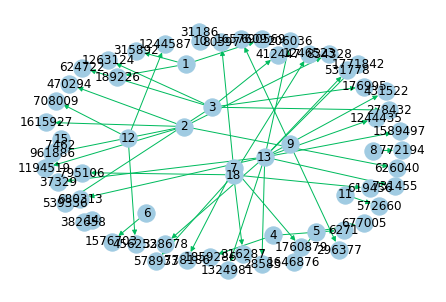

In [ ]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [ ]:
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1581182


## 1.1 No of followers for each person

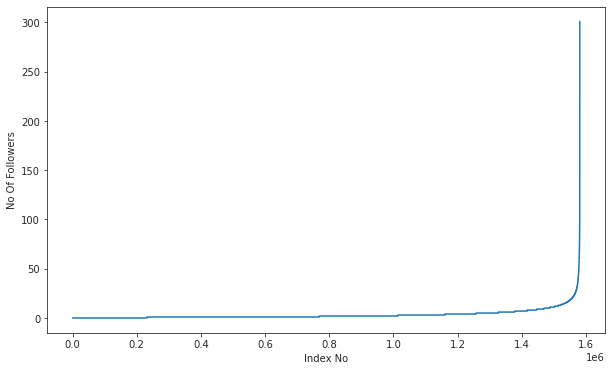

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

In [ ]:
len(indegree_dist)

1581182

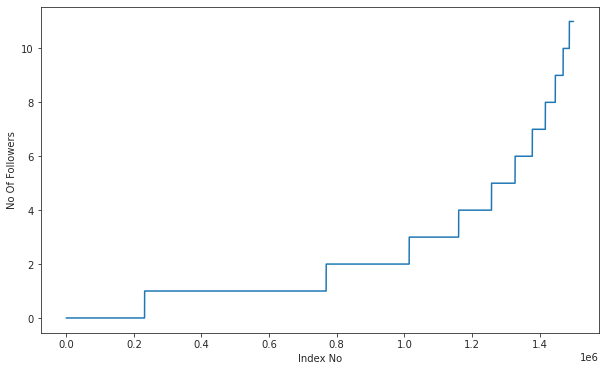

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

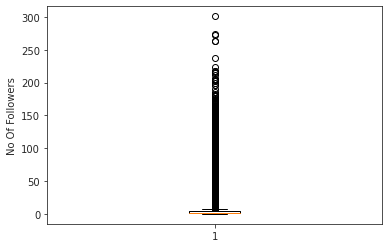

In [ ]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [ ]:
min(indegree_dist)

0

In [ ]:
np.percentile(indegree_dist,0)

0.0

In [ ]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 8.0
91 percentile value is 8.0
92 percentile value is 9.0
93 percentile value is 10.0
94 percentile value is 10.0
95 percentile value is 11.0
96 percentile value is 13.0
97 percentile value is 15.0
98 percentile value is 18.0
99 percentile value is 24.0
100 percentile value is 301.0


99% of data having followers of 40 only.

In [ ]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 25.0
99.2 percentile value is 27.0
99.3 percentile value is 28.0
99.4 percentile value is 30.0
99.5 percentile value is 33.0
99.6 percentile value is 37.0
99.7 percentile value is 42.0
99.8 percentile value is 50.0
99.9 percentile value is 66.0
100.0 percentile value is 301.0


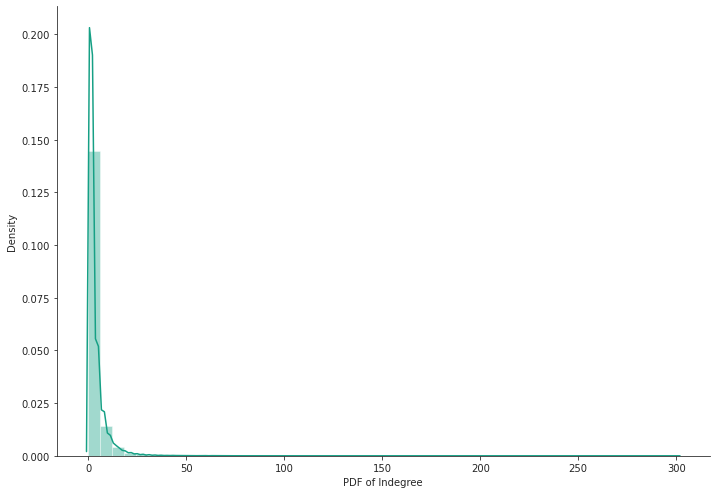

In [ ]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

## 1.2 No of people each person is following

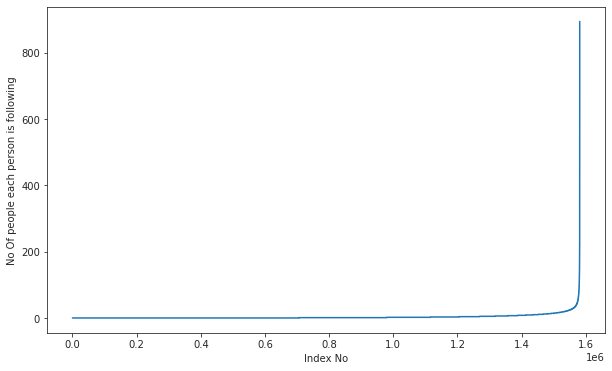

In [ ]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

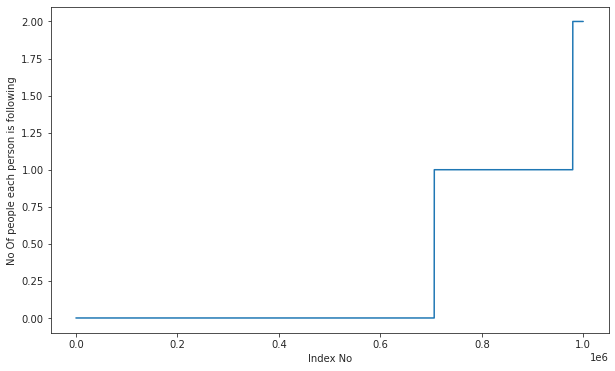

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1000000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

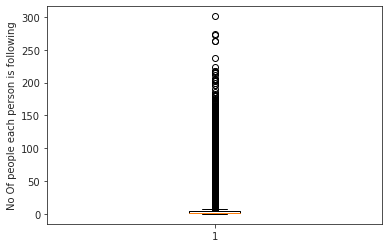

In [ ]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

In [ ]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 9.0
91 percentile value is 10.0
92 percentile value is 11.0
93 percentile value is 12.0
94 percentile value is 13.0
95 percentile value is 15.0
96 percentile value is 17.0
97 percentile value is 19.0
98 percentile value is 24.0
99 percentile value is 33.0
100 percentile value is 895.0


In [ ]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 34.0
99.2 percentile value is 36.0
99.3 percentile value is 39.0
99.4 percentile value is 42.0
99.5 percentile value is 45.0
99.6 percentile value is 51.0
99.7 percentile value is 58.0
99.8 percentile value is 72.0
99.9 percentile value is 101.0
100.0 percentile value is 895.0


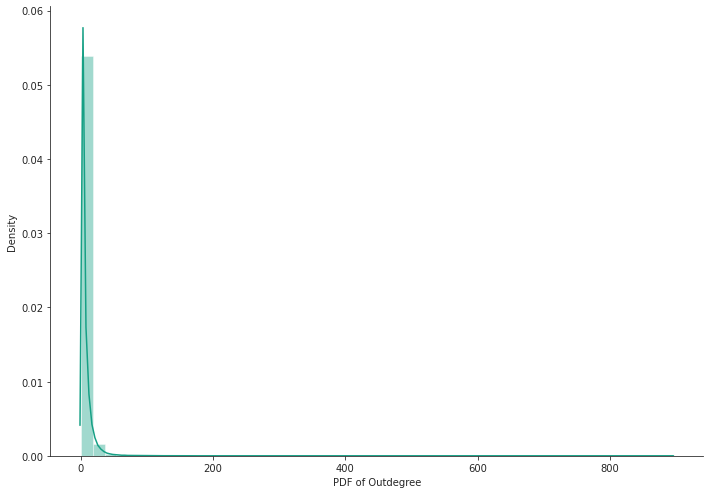

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [ ]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 706237 and % is 44.665130263309344


In [ ]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 231680 and % is 14.652329712835082


In [ ]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


## 1.3 both followers + following 

In [ ]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

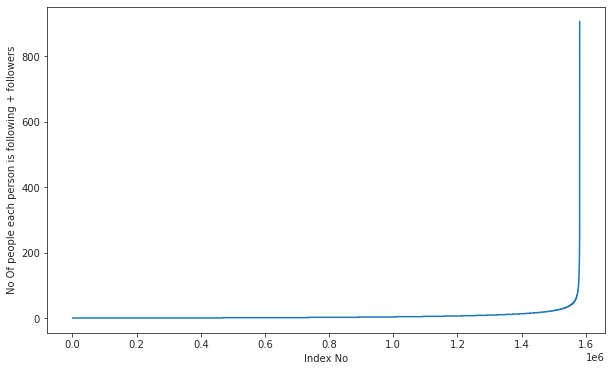

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

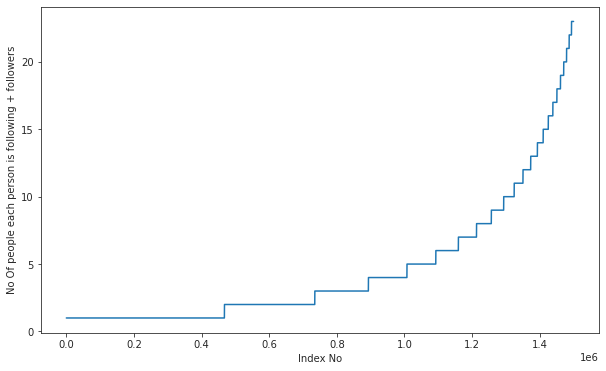

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [ ]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 15.0
91 percentile value is 17.0
92 percentile value is 18.0
93 percentile value is 19.0
94 percentile value is 21.0
95 percentile value is 24.0
96 percentile value is 27.0
97 percentile value is 31.0
98 percentile value is 38.0
99 percentile value is 53.0
100 percentile value is 906.0


In [ ]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 55.0
99.2 percentile value is 58.0
99.3 percentile value is 62.0
99.4 percentile value is 66.0
99.5 percentile value is 71.0
99.6 percentile value is 79.0
99.7 percentile value is 90.0
99.8 percentile value is 108.0
99.9 percentile value is 149.0
100.0 percentile value is 906.0


In [ ]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
467404  persons having minimum no of followers + following


In [ ]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 906
1  persons having maximum no of followers + following


In [ ]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1293134


In [ ]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 50682
weakly connected components wit 2 nodes 35750


# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [ ]:
import random
if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    r = csv.reader(open('train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.p','rb'))

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [ ]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('train_pos_after_eda.csv')) or (not os.path.isfile('test_pos_after_eda.csv')):
    df_pos = pd.read_csv('train.csv')
    df_pos.dropna(axis=0,inplace=True)
    df_pos.destination_node=df_pos.destination_node.apply(int)
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Spiltted data into 80-20 
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    X_train_pos.to_csv('train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('test_neg_after_eda.csv',header=False, index=False)
else:
    del missing_edges

Number of nodes in the graph with edges 5202014
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 4161611 = 4161611
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1040403 = 1040403
Number of nodes in the test data graph without edges 1887504 = 1887504


In [ ]:
df_pos[:2]

,source_node,destination_node
0,1,690569
1,1,315892


In [ ]:
if (os.path.isfile('train_pos_after_eda.csv')) and (os.path.isfile('test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1475493
Number of edges: 4161611
Average in degree:   2.8205
Average out degree:   2.8205
Name: 
Type: DiGraph
Number of nodes: 828767
Number of edges: 1040403
Average in degree:   1.2554
Average out degree:   1.2554
no of people common in train and test --  723078
no of people present in train but not present in test --  752415
no of people present in test but not present in train --  105689
 % of people not there in Train but exist in Test in total Test data are 12.752558921868271 %


> we have a cold start problem here

In [ ]:
if (not os.path.isfile('train_after_eda.csv')) and \
(not os.path.isfile('test_after_eda.csv')) and \
(not os.path.isfile('train_y.csv')) and \
(not os.path.isfile('test_y.csv')) and \
(os.path.isfile('train_pos_after_eda.csv')) and \
(os.path.isfile('test_pos_after_eda.csv')) and \
(os.path.isfile('train_neg_after_eda.csv')) and \
(os.path.isfile('test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('train_after_eda.csv',header=False,index=False)
    X_test.to_csv('test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 4161611
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1040403
Number of nodes in the test data graph without edges 1887504


In [ ]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (11711626, 2)
Data points in test data (2927907, 2)
Shape of traget variable in train (11711626,)
Shape of traget variable in test (2927907,)
